# Image Classification
 Rock-Paper-Scissors

## Importing Module

In [1]:
import os
import random
import zipfile
import urllib.request
import tensorflow as tf
import matplotlib.image as mpimg


from pathlib import Path
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

print(f'Tensorflow Version : {tf.__version__}')

Tensorflow Version : 2.8.2


## Problem

- Your input layer should accept `150x150` with 3 bytes color as the input shape.
- This is unlabeled data, use ImageDataGenerator to automatically label it.
- Don't use lambda layers in your model.

- The dataset used in this problem is originally published in https://www.kaggle.com/c/dogs-vs-cats/data

- Desired accuracy and validation_accuracy > `72%`

### Preparing data

In [4]:
data_url = 'https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/cats_and_dogs.zip'

name_file = 'cats_and_dogs.zip'
target_path = 'data/'

if os.path.isfile(name_file):
    print(f'{name_file} Already exist')
else:
  # Download file
  urllib.request.urlretrieve(data_url, name_file)

  # Extract file
  zip_ref = zipfile.ZipFile(name_file, 'r')
  zip_ref.extractall(target_path)
  zip_ref.close()
  print(f'{name_file} Download and Extract finished')

cats_and_dogs.zip Already exist


In [5]:
! rm /content/data/cats_and_dogs_filtered/vectorize.py

Check total file

In [8]:
list_dir = os.listdir(base_dir)
list_dir

['validation', 'train']

In [12]:
base_dir = Path('./data/cats_and_dogs_filtered/')

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

list_dir = os.listdir(base_dir)

image_count = len(list(base_dir.glob("*/*/*")))
print(f'Total Image : {image_count}\n')
for dir in list_dir:
  image_count_dir = len(list(base_dir.glob(f'{dir}/*/*.jpg')))
  print(f'Total Image {dir} : {image_count_dir}')
  image_dir = os.path.join(base_dir, dir)
  for i in os.listdir(image_dir):
    class_dir = os.path.join(image_dir, i)
    class_dir = os.listdir(class_dir)
    print(f'{i} : {len(class_dir)}')
  print()

Total Image : 3000

Total Image validation : 1000
cats : 500
dogs : 500

Total Image train : 2000
cats : 1000
dogs : 1000



### Explore data

In [13]:
def load_random_imgs_from_folder(folder,label):
  plt.figure(figsize=(15,15))
  for i in range(3):
    file = random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,3,i+1)
    ax.title.set_text(label)
    plt.xlabel(f'Name: {file}')
    plt.imshow(img)

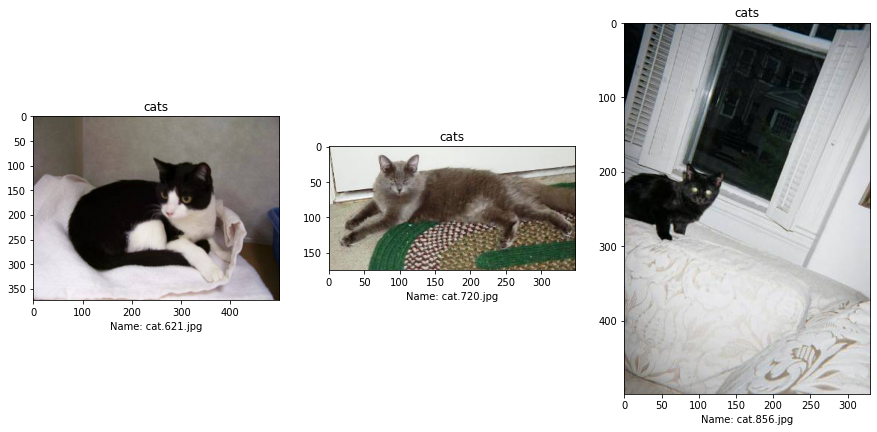

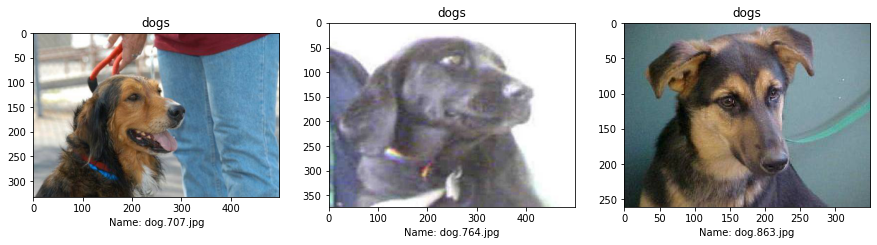

In [15]:
for dir in os.listdir(train_dir):
  image_dir = os.path.join(train_dir, dir)
  load_random_imgs_from_folder(image_dir, dir)

### Preparing Train Model

Set Paramters

In [16]:
IMG_SIZE = (150,150)
BATCH_SIZE = 64

#### Image Augmentation
Using [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [17]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle = True,
                                                    class_mode='binary')


test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=IMG_SIZE,
                                                        batch_size=BATCH_SIZE//2,
                                                        shuffle = True,
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Build Model

In [30]:
def build_model():
  """
  Create a model sequential with convolutional layers

  Returns:
      model (tf.keras Model): the Image classifier model
  """

  # Define Params
  lr = 1e-3
  adam = tf.keras.optimizers.Adam(learning_rate=lr) # Optimizer
  losses = tf.keras.losses.BinaryCrossentropy()

  # Define Activation Function
  relu = tf.nn.relu
  sigmoid = tf.nn.sigmoid

  # Define model sequential
  model = tf.keras.Sequential()

  # Define convolutional layers
  model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation=relu, input_shape=IMG_SIZE + (3,)))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation=relu))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation=relu))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))

  # Define fully connected layers
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(512, activation=relu))
  model.add(tf.keras.layers.Dense(1, activation=sigmoid))

  # Compile model
  model.compile(optimizer=adam, loss=losses, metrics=['accuracy'])

  # Check Summary Model
  model.summary()

  print('\nModel Successfully Create')
  
  return model

In [31]:
model = build_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 18, 18, 64)      

#### Define Callbacks

In [32]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", 
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=10, 
                                                  mode ="max", 
                                                  verbose=2, 
                                                  restore_best_weights=True)

### Train Model

In [33]:
history = model.fit(
      train_generator,
      epochs=20,
      verbose=1,
      validation_data = validation_generator,
      callbacks=[model_checkpoint, early_stopping])

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 0.8733 - accuracy: 0.4900
Epoch 1: val_accuracy improved from -inf to 0.54100, saving model to model.h5
32/32 [==============================] - 17s 519ms/step - loss: 0.8733 - accuracy: 0.4900 - val_loss: 0.6897 - val_accuracy: 0.5410
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.5345
Epoch 2: val_accuracy did not improve from 0.54100
32/32 [==============================] - 16s 506ms/step - loss: 0.6851 - accuracy: 0.5345 - val_loss: 0.6729 - val_accuracy: 0.5170
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 0.6558 - accuracy: 0.5965
Epoch 3: val_accuracy improved from 0.54100 to 0.63400, saving model to model.h5
32/32 [==============================] - 16s 517ms/step - loss: 0.6558 - accuracy: 0.5965 - val_loss: 0.6341 - val_accuracy: 0.6340
Epoch 4/20
32/32 [==============================] - ETA: 0s - loss: 0.6305 - accuracy: 0.6450
Epoch 4: val_accur

### Visualization result

In [25]:
def visualize_result(history):
  '''Function for Visual result'''
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='best')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='best')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

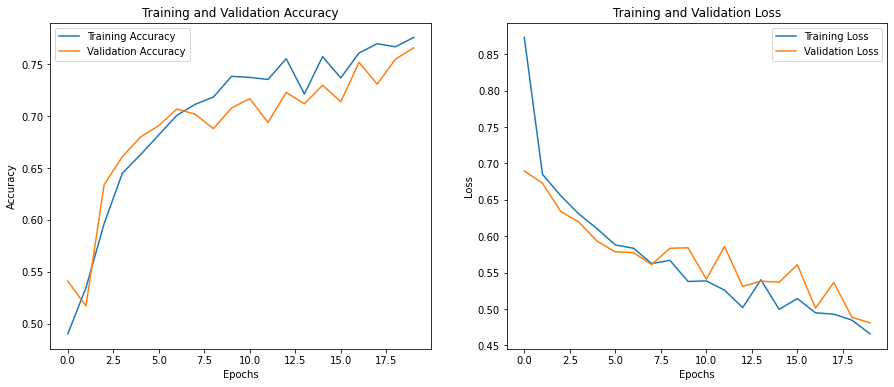

In [34]:
visualize_result(history)

### Download Model

In [ ]:
from google.colab import files
files.download('model.h5') 